<a href="https://colab.research.google.com/github/Kaan-wq/ml_tokamak/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import os
import glob
import numpy as np
from typing import Iterable
import pickle
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.datasets._samples_generator import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.utils.extmath import row_norms
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score

In [ ]:
# load dataset using pickle
import pickle
with open("/content/drive/MyDrive/dataset_disruption_characterization.pickle", "rb") as f:
    dataset = pickle.load(f)

In [ ]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']
    metadata = entry['metadata']
    event = metadata['time_event']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])
    df['Time'] = d['time']
    df['Frame'] = range(0, 20)

    if event:
      #Find closest points to time_event
      differences = np.abs(df['Time'] - event)
      closest_indices = np.argsort(differences)[:20]

      #Assign labels to closest points
      df['Label'] = 0
      df.loc[closest_indices, 'Label'] = label
    else:
      df['Label'] = label

    df['Shot'] = metadata['shot']
    df['Window'] = i  # Add the window number

    contains_nan = df.isna().any().any()

    if not contains_nan:
      # Append the current DataFrame to the main DataFrame
      df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()

display(df_data)
print("Labels count:")
print(f"{df_data['Label'].value_counts()}")

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,Time,Frame,Label,Shot,Window
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,10.361,0,0,81206,0
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,10.362,1,0,81206,0
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,10.363,2,0,81206,0
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,10.364,3,0,81206,0
4,1990532.250,1999500.0,1746.057251,0.008850,1.191489,3.874169,0.30388,0.237256,10.365,4,0,81206,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,3993662.500,4000500.0,6282.263672,1.416517,0.808256,2.898196,0.32961,-0.316564,8.622,15,0,98005,905
17976,3995614.250,4000500.0,6303.055664,1.410871,0.808256,2.898196,0.32961,-0.237256,8.623,16,0,98005,905
17977,3994348.000,4000500.0,6277.216309,1.402783,0.808256,2.898196,0.32961,-0.238922,8.624,17,0,98005,905
17978,3997734.500,4000500.0,6286.124512,1.391034,0.808256,2.898196,0.32961,0.279242,8.625,18,0,98005,905


Labels count:
0    12840
1     4140
2     1000
Name: Label, dtype: int64


#**Unsupervised Learning**

Below we will try various unsupervised learning methods

##**K-Means**

In this section we try a naive k-means solution for 3 clusters.

The features of the first sample are: [190384.89126569 -34981.03439561   -357.90626182]


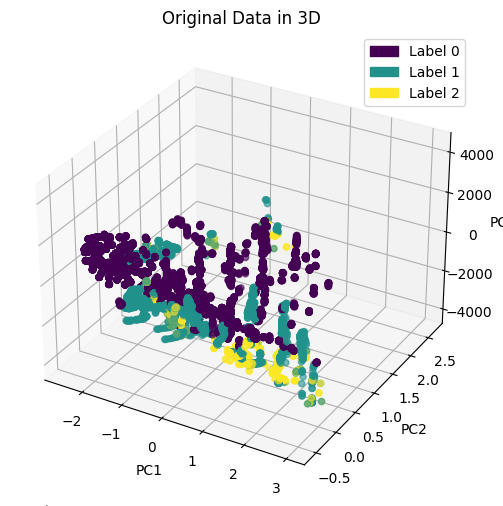

In [ ]:
x = df_data.drop(['Label', 'Window', 'Shot'], axis=1).values
x_pca = PCA(n_components=3).fit(x).transform(x)

print("The features of the first sample are: %s" % x_pca[0])

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=df_data['Label'], alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("Original Data in 3D")

# Create a legend
unique_labels = np.unique(df_data['Label'])
colors = scatter.to_rgba(unique_labels)
legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
ax.legend(handles=legend_handles)

plt.show()

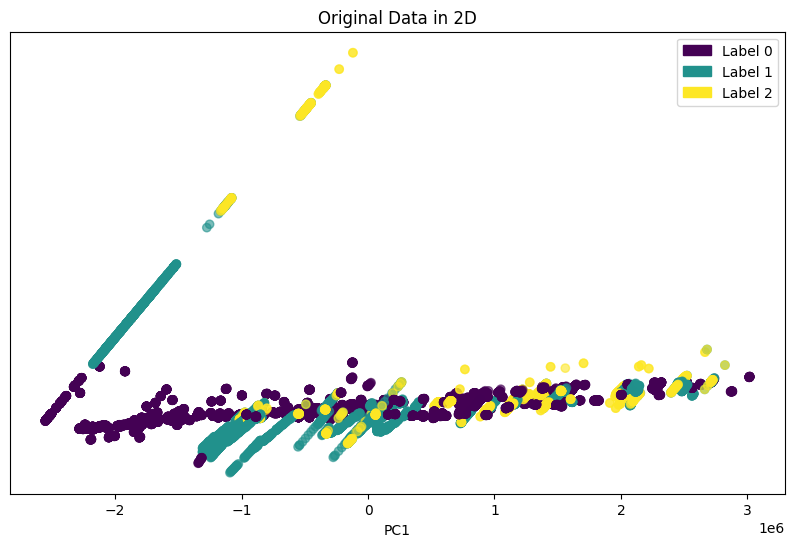

In [ ]:
dd = PCA(n_components=2).fit(x).transform(x)

# Creating a 1D plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot using the first PCA component
scatter = ax.scatter(dd[:, 0], dd[:, 1], c=df_data['Label'], alpha=0.6)

ax.set_xlabel('PC1')
ax.set_title("Original Data in 2D")
ax.axes.get_yaxis().set_visible(False)  # Hide the y axis

# Create a legend
unique_labels = np.unique(df_data['Label'])
colors = scatter.to_rgba(unique_labels)
legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
ax.legend(handles=legend_handles)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


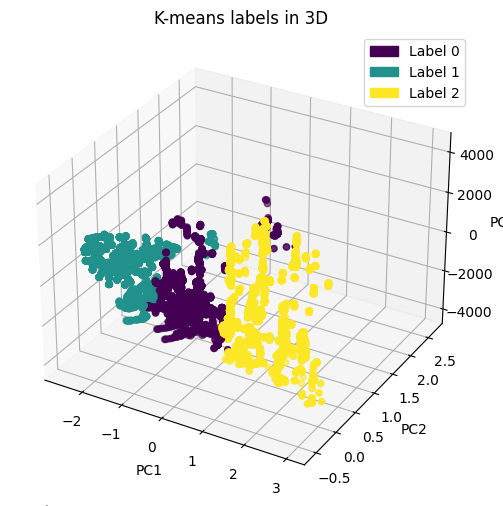

In [ ]:
label = KMeans(n_clusters=3, random_state=0).fit_predict(x)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=label, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("K-means labels in 3D")

# Create a legend
unique_labels = np.unique(label)
colors = scatter.to_rgba(unique_labels)
legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
ax.legend(handles=legend_handles)

plt.show()

##**Gaussian Mixture Model**

In this section we try to cluster our data using a GMM with a variety of initialisation methods.

In [ ]:
X = df_data.drop(['Label', 'Window', 'Shot'], axis=1).values
x_pca = PCA(n_components=3).fit(X).transform(X)

clusters = 3
tol = 1e-9
max_iter = 2000

def get_initial_means(X, init_params, r):
    # Run a GaussianMixture with max_iter=0 to output the initialization means
    gmm = GaussianMixture(
        n_components=clusters, init_params=init_params, tol=tol, max_iter=0, random_state=r
    ).fit(X)
    return gmm.means_

methods = ["kmeans", "random_from_data", "k-means++", "random"]

labels = []
probas = []

for n, method in enumerate(methods):
    r = np.random.RandomState(seed=1234)

    ini = get_initial_means(X, method, r)

    gmm = GaussianMixture(
        n_components=clusters, means_init=ini, tol=tol, max_iter=max_iter, random_state=r
    ).fit(X)

    labels.append(gmm.predict(X))
    probas.append(gmm.predict_proba(X))

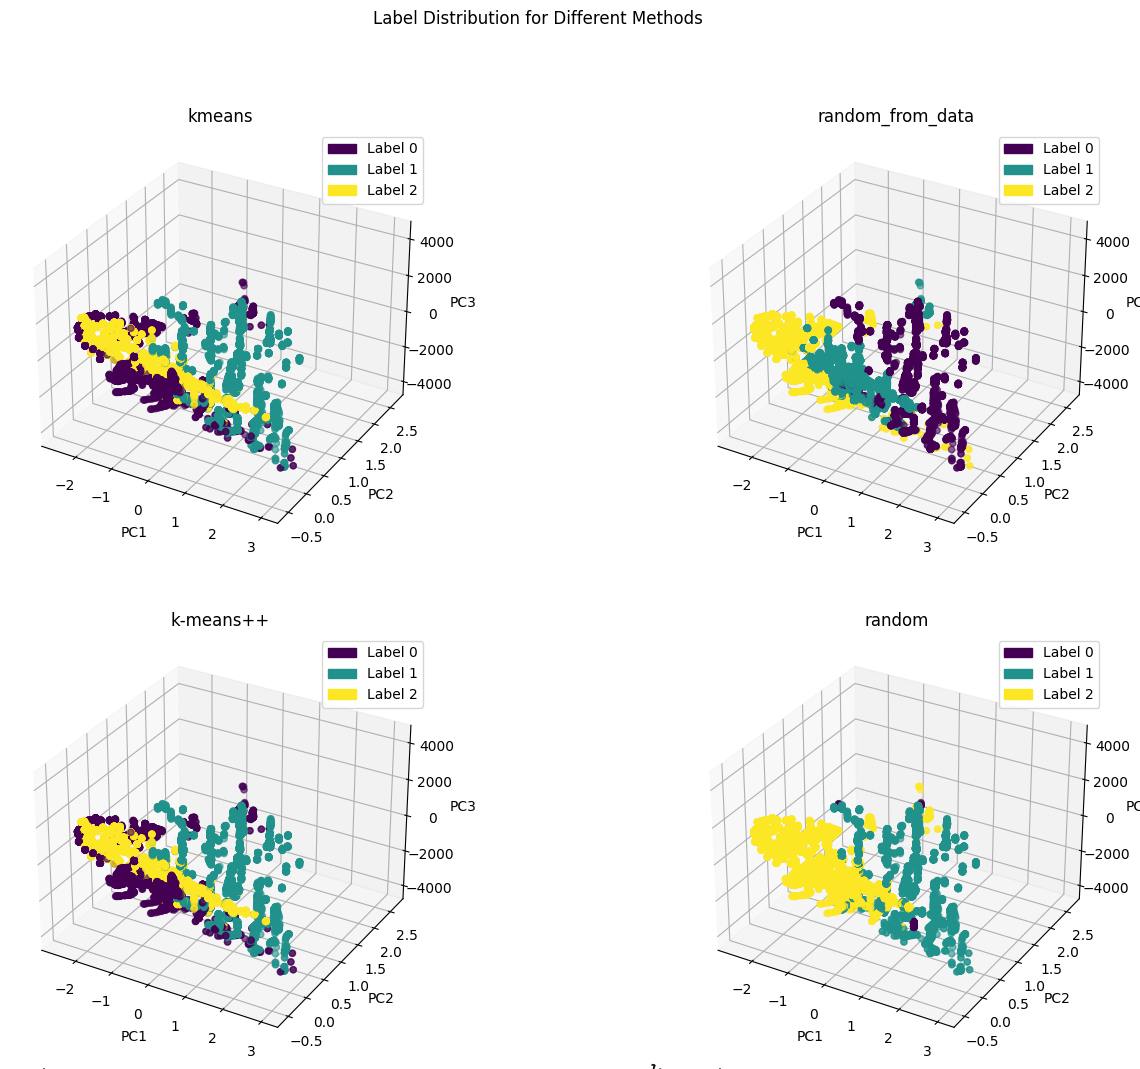

In [ ]:
fig = plt.figure(figsize=(16, 12))

for i, method in enumerate(methods):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')

    # Scatter plot for each method
    scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=labels[i], alpha=0.6)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(method)

    # Create a legend
    unique_labels = np.unique(labels[i])
    colors = scatter.to_rgba(unique_labels)
    legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
    ax.legend(handles=legend_handles)

plt.suptitle("Label Distribution for Different Methods")
plt.show()

###**Observations**

We see that with k-means ++ initialization we get pretty good results ! \
The clusters are approximately of the same shape of our original data, the only issue is that the labels don't correspond but we can simply intervert them.

In [ ]:
label_map = (labels[2] + 1)%3

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=label_map, alpha=0.6)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("K-means++ in 3D")

# Create a legend
unique_labels = np.unique(label_map)
colors = scatter.to_rgba(unique_labels)
legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
ax.legend(handles=legend_handles)

plt.show()

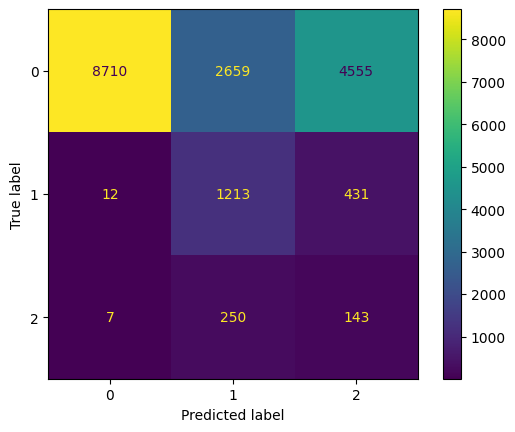

In [ ]:
y_true = df_data['Label'].values
y_pred = label_map

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

recall = recall_score(y_true, y_pred, average='weighted')
print("Recall:", recall)

# Use 'micro', 'macro', 'weighted', or 'samples' for multiclass classification.
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.5598442714126808
Recall: 0.5598442714126808
F1 Score: 0.665629273538323


##**DB-SCAN**

In this section we try the famous db-scan algorithm to find our clusters.

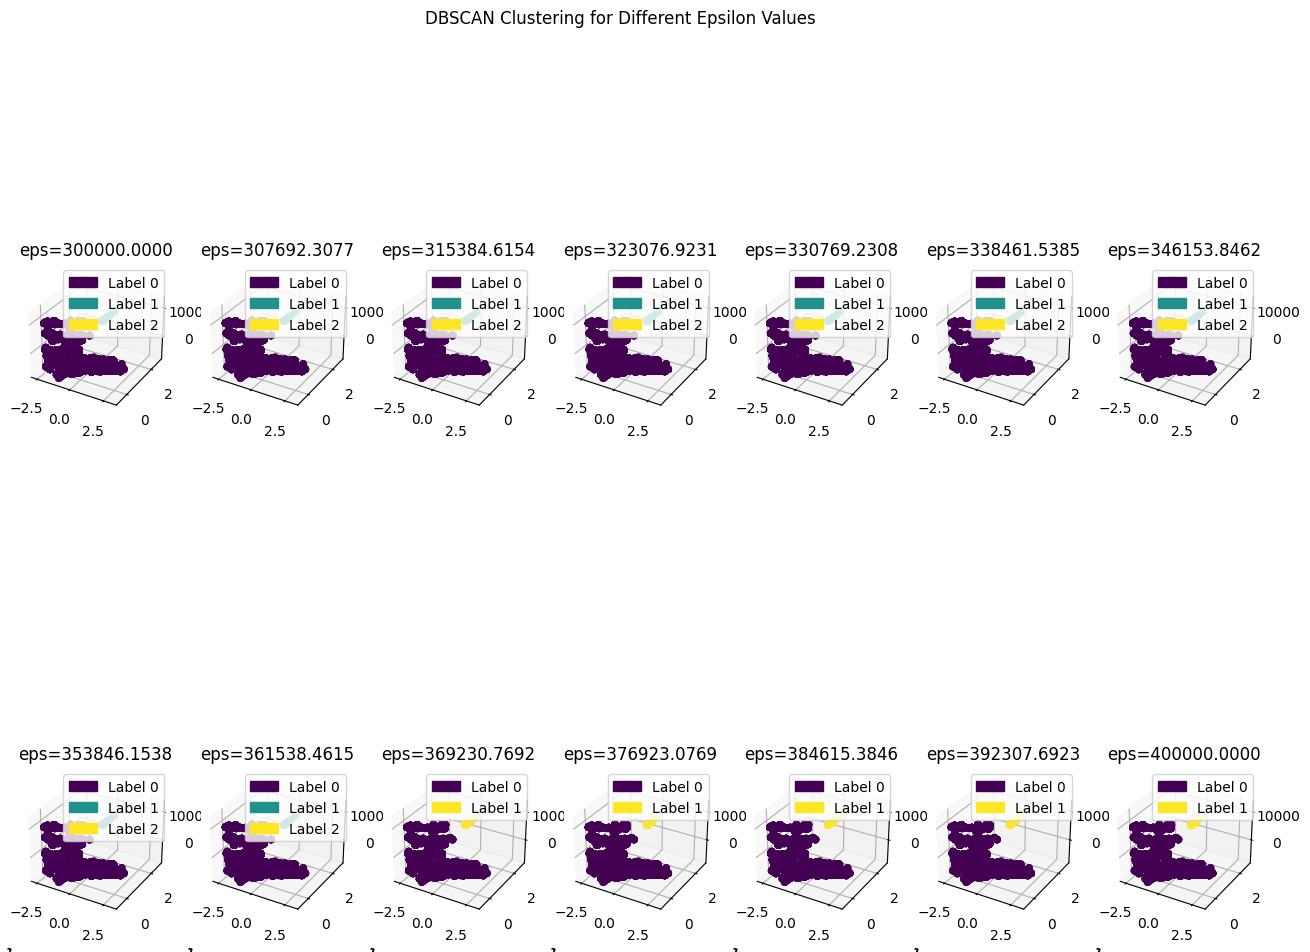

In [ ]:
x = df_data.drop(['Label', 'Window'], axis=1).values
x_pca = PCA(n_components=3).fit(x).transform(x)

eps_list = np.linspace(300000, 400000, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list) / COLUMNS)

fig = plt.figure(figsize=(16, 12))

for i in range(len(eps_list)):
    ax = fig.add_subplot(ROWS, COLUMNS, i + 1, projection='3d')
    eps = eps_list[i]
    label_scan = DBSCAN(eps=eps).fit_predict(x)

    # Scatter plot for each epsilon value
    scatter = ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=label_scan, alpha=0.6)
    ax.set_title(f"eps={eps:.4f}")

    # Create a legend
    unique_labels = np.unique(label_scan)
    colors = scatter.to_rgba(unique_labels)
    legend_handles = [mpatches.Patch(color=colors[label], label=f'Label {label}') for label in unique_labels]
    ax.legend(handles=legend_handles)

plt.suptitle("DBSCAN Clustering for Different Epsilon Values")
plt.show()

We see that the DB-SCAN algorithm is terrible with our data